In [1]:
import os
import json
import numpy as np
from skimage import io as skio
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage.measure import label

In [2]:
import javabridge as jv, bioformats as bf
jv.start_vm(class_path=bf.JARS, max_heap_size='4G')

def get_stack_from_series_id(czi_path, channel, series_id, dim):

    # Extraction a series from multi-position CZI

    img_raw = []
    for slice in range(dim[0]):
        img_raw.append(bf.load_image(path=czi_path, series=series_id, c=channel, z=slice, t=0, rescale=False))
    img_raw = np.array(img_raw).reshape(*dim)

    return img_raw

from skimage.filters import gaussian
from skimage.morphology import extrema, binary_dilation

def norm_and_smooth(img_original):

    # Uses Jianxu's normalization and Gaussian smooth to
    # preprocess the input image. Parameters have default
    # values used in the segmentation toolkit.

    smooth_sigma = 1.0
    scaling_params = [0.5, 18]

    img_norm = img_original.copy()
    mean = img_norm.mean()
    stdv = img_norm.std()
    strech_min = np.max([mean-scaling_params[0]*stdv, img_norm.min()])
    strech_max = np.min([mean+scaling_params[1]*stdv, img_norm.max()])
    img_norm[img_norm > strech_max] = strech_max
    img_norm[img_norm < strech_min] = strech_min
    img_norm = (img_norm-strech_min + 1e-8)/(strech_max-strech_min + 1e-8)
    img_norm = gaussian(image=img_norm, sigma=smooth_sigma)

    # img_norm may contain negative values

    return img_norm

In [ ]:
with open("../config-mix.json", "r") as fj:
    config_json = json.load(fj)
config_json = config_json["data"]
config_czi = config_json[0]
config_czi["raw_path"]

In [3]:
raw_path = "/allen/aics/assay-dev/MicroscopyData/Caroline/2018/20181016/20181016_C04_011_Out.czi"
seg_mem_name = "/allen/aics/assay-dev/MicroscopyOtherData/Jianxu/Nucleus/segmentation/880_HIPSC_H2B_No_1/shape/20181016_C04_011_Out_seg_0.ome.tif"
seg_nuc_name = "/allen/aics/assay-dev/MicroscopyOtherData/Jianxu/Nucleus/segmentation/880_HIPSC_H2B_No_1/shape/20181016_C04_011_Out_seg_0.ome.tif"

(63, 662, 662) (63, 662, 662)


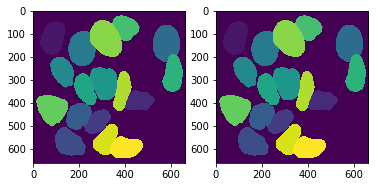

In [7]:
img_mem_seg_all = skio.imread(seg_mem_name)
img_dna_seg_all = skio.imread(seg_nuc_name)
nz, ny, nx = img_mem_seg_all.shape
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_mem_seg_all.max(axis=0))
ax[1].imshow(img_dna_seg_all.max(axis=0))
print(img_mem_seg_all.shape,img_dna_seg_all.shape)

In [8]:
img_raw = get_stack_from_series_id(czi_path=raw_path, channel=0, series_id=0, dim=(nz,ny,nx))
plt.imshow(img_raw[int(0.5*nz),:,:])

ValueError: cannot reshape array of size 110437488 into shape (63,662,662)

In [ ]:
img_mem_seg = img_mem_seg_all.copy()
img_mem_seg[img_mem_seg==1] = 1
img_mem_seg[img_mem_seg!=1] = 0
pxl_z, pxl_y, pxl_x = np.nonzero(img_mem_seg)
plt.imshow(img_mem_seg.mean(axis=0))
print(np.ptp(pxl_z),np.ptp(pxl_y),np.ptp(pxl_x))

In [ ]:
print(img_seg.shape[0]*img_seg.shape[1]*img_seg.shape[2])
img_seg = label(img_seg)
print("#Comps:",np.unique(img_seg))
print("Sizes:",np.bincount(img_seg.flat,minlength=img_seg.max()))
largest_cc = 1 + np.argmax(np.bincount(img_seg.flat)[1:])
print("Largest CC:", largest_cc)

In [ ]:
if img_seg.max() > 1:
    img_seg[img_seg!=largest_cc] = 0
    img_seg[img_seg>0] = 1
plt.imshow(img_seg.max(axis=0))
plt.imshow(img_seg.max(axis=1))

In [ ]:
img_input = img_raw * img_seg

In [ ]:
pxl_z, pxl_y, pxl_x = np.nonzero(img_input)
img_raw_crop = img_input[pxl_z.min():(pxl_z.max()+1),pxl_y.min():(pxl_y.max()+1),pxl_x.min():(pxl_x.max()+1)]
plt.imshow(img_raw_crop.max(axis=1))

In [ ]:
nz_crop, ny_crop, nx_crop = img_raw_crop.shape
nz_crop_new = np.int((config_czi["pixel_size_z"]/config_czi["pixel_size_xy"])*nz_crop)
print(img_raw_crop.shape, img_raw_crop.dtype)
img_raw_crop_resize = resize(image=img_raw_crop, output_shape=(nz_crop_new,ny_crop,nx_crop), preserve_range=True, anti_aliasing=True, mode="constant")
img_raw_crop_resize = img_raw_crop_resize.astype(np.int64)
print(img_raw_crop_resize.shape)
print(img_raw_crop_resize.dtype,img_raw_crop_resize.min(),img_raw_crop_resize.max())
fig, ax = plt.subplots(nrows=1,ncols=2)
ax[0].imshow(img_raw_crop_resize.max(axis=0))
ax[1].imshow(img_raw_crop_resize.max(axis=1))

img_input = img_raw_crop_resize

In [ ]:
img_norm = norm_and_smooth(img_original=img_input)

In [ ]:
img_max = extrema.h_maxima(img_norm, h=0.25)
z_pxl, y_pxl, x_pxl = np.nonzero(img_max)
print(len(z_pxl))

In [ ]:
img_input[0,0] = 2000
avg = img_input[img_input>0].mean()
std = img_input[img_input>0].std()
fig, ax = plt.subplots(nrows=2,ncols=2)
fig.suptitle(config_czi["])
ax[0,0].imshow(img_input.max(axis=0))
ax[0,0].plot(x_pxl,y_pxl,"r+")
ax[0,1].imshow(img_input.max(axis=0)>(avg+2.0*std))
ax[1,0].imshow(img_input.max(axis=1))
ax[1,0].plot(x_pxl,z_pxl,"r+")
ax[1,1].imshow(img_input.max(axis=1)>(avg+2.0*std))